In [6]:
%matplotlib inline

### Transfer Learning

Neste notebook vamos mostrar como utilizar a rede SqueezeNet treinada sobre a ImageNet para resolver outros tipos de problema de maneira rápida.

Treinar uma rede completa pode ser muito custoso e demanda uma quantidade relevante de dados, por isso essa estratégia é muito utilizada, especialmente em problemas de imagens.

No caso da SqueezeNet, os primeiros filtros convolucionais são capazes de detectar elementos, cantos ou cores, que são comuns em qualquer domínio de imagens.

In [7]:
import os
import numpy as np
from random import sample, seed
seed(42)
np.random.seed(42)

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (15,15) # Make the figures a bit bigger

# Keras imports
from keras.layers import Input, Convolution2D, MaxPooling2D, Activation, concatenate, Dropout, GlobalAveragePooling2D
from keras.models import Model
from keras.applications.imagenet_utils import preprocess_input, decode_predictions
from keras.preprocessing.image import load_img, img_to_array
from keras.utils import get_file
from keras.datasets import cifar10
from sklearn.model_selection import StratifiedShuffleSplit
from keras.utils import np_utils

#plot the imgList
def plotImages(imgList):
    for i in range(len(imgList)):
        plotImage(imgList[i])
        
        
def plotImage(img):
    fig = plt.figure(figsize=(1,1))
    ax = fig.add_subplot(111)

    ax.imshow(np.uint8(img), interpolation='nearest')
    plt.show()

In [8]:
sq1x1 = "squeeze1x1"
exp1x1 = "expand1x1"
exp3x3 = "expand3x3"
relu = "relu_"

# Modular function for Fire Node
def fire_module(x, fire_id, squeeze=16, expand=64):
    s_id = 'fire' + str(fire_id) + '/'

    channel_axis = 3
    
    x = Convolution2D(squeeze, (1, 1), padding='valid', name=s_id + sq1x1)(x)
    x = Activation('relu', name=s_id + relu + sq1x1)(x)

    left = Convolution2D(expand, (1, 1), padding='valid', name=s_id + exp1x1)(x)
    left = Activation('relu', name=s_id + relu + exp1x1)(left)

    right = Convolution2D(expand, (3, 3), padding='same', name=s_id + exp3x3)(x)
    right = Activation('relu', name=s_id + relu + exp3x3)(right)

    x = concatenate([left, right], axis=channel_axis, name=s_id + 'concat')
    return x

In [9]:
def SqueezeNet(input_shape=None, weights_path=None, classes=1000):
    """Instantiates the SqueezeNet architecture.
    """
    img_input = Input(shape=input_shape)

    x = Convolution2D(64, (3, 3), strides=(2, 2), padding='valid', name='conv1')(img_input)
    x = Activation('relu', name='relu_conv1')(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool1')(x)

    x = fire_module(x, fire_id=2, squeeze=16, expand=64)
    x = fire_module(x, fire_id=3, squeeze=16, expand=64)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool3')(x)

    x = fire_module(x, fire_id=4, squeeze=32, expand=128)
    x = fire_module(x, fire_id=5, squeeze=32, expand=128)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool5')(x)

    x = fire_module(x, fire_id=6, squeeze=48, expand=192)
    x = fire_module(x, fire_id=7, squeeze=48, expand=192)
    x = fire_module(x, fire_id=8, squeeze=64, expand=256)
    x = fire_module(x, fire_id=9, squeeze=64, expand=256)
    
    x = Dropout(0.5, name='drop9')(x)

    x = Convolution2D(classes, (1, 1), padding='valid', name='conv10')(x)
    x = Activation('relu', name='relu_conv10')(x)
    x = GlobalAveragePooling2D()(x)
    x = Activation('softmax', name='loss')(x)

    model = Model(img_input, x, name='squeezenet')
    
    if weights_path != None:
        model.load_weights(weights_path)
    
    return model

### CIFAR-10

CIFAR-10 é um dataset de imagens incluído na biblioteca Keras para testes e treinamento de modelos. O conjunto de dados consiste de 60000 imagens coloridas de dimensão 32x32 divididas em 10 classes balanceadas (6000 imagens por classe). O dataset já é dividido em 50000 imagens para treinamento e 10000 para testes.

As classes do CIFAR-10 são: **aviões, automóveis, pássaros, gatos, alces, cachorros, sapos, cavalos, navios, caminhões.**

Vamos começar carregando os dados.

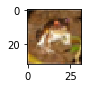

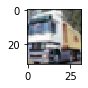

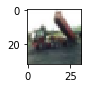

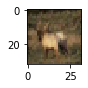

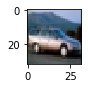

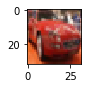

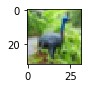

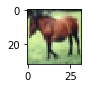

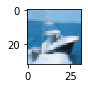

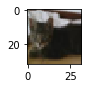

In [10]:
(train_data, train_label), (X_test, y_test) = cifar10.load_data()

plotImages(train_data[:10])

Em seguida, faremos o tratamento das imagens similar aos tratamentos feitos em outros notebooks desse bootcamp. Vamos dividir o dataset de treino em treino e validação, alterar o range dos dados para [0-1], bem como alterar nosso vetor y para que cada classe represente uma coluna.

In [11]:
splitIdx = StratifiedShuffleSplit(1, test_size=10000, random_state=0)
for train_index, val_index in splitIdx.split(train_data, train_label):
    X_train, X_val = train_data[train_index], train_data[val_index]
    y_train, y_val = train_label[train_index], train_label[val_index]
    
#Transform data
X_train = X_train.reshape(X_train.shape[0], 32, 32, 3)
X_val = X_val.reshape(X_val.shape[0], 32, 32, 3)
X_test = X_test.reshape(X_test.shape[0], 32, 32, 3)

X_train = X_train.astype('float32')
X_val = X_val.astype('float32')
X_test = X_test.astype('float32')

X_train /= 255
X_val /= 255
X_test /= 255

print("Training matrix shape", X_train.shape)
print("Validation matrix shape", X_val.shape)
print("Testing matrix shape", X_test.shape)

Y_train = np_utils.to_categorical(y_train, 10)
Y_val = np_utils.to_categorical(y_val, 10)
Y_test = np_utils.to_categorical(y_test, 10)

Training matrix shape (40000, 32, 32, 3)
Validation matrix shape (10000, 32, 32, 3)
Testing matrix shape (10000, 32, 32, 3)


### Abordagem 1 - Alterar apenas a camada de classificação

Nesta primeira abordagem de Transferência de Aprendizado, vamos congelar as camadas da nossa rede treinada e alterar apenas a camada de classificação para classificar as imagens em 10 classes (ao invés de 1000).

In [0]:
squeezeNetModel = SqueezeNet((32,32,3), "squeezenet_weights_tf_dim_ordering_tf_kernels.h5")

#freeze layers
for layer in squeezeNetModel.layers:
    layer.trainable = False

#Add new classification layers

# create new model


In [0]:
#Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(X_train, Y_train, batch_size=64, epochs=10,
                  validation_data=(X_val, Y_val))

In [0]:
score = model.evaluate(X_test,Y_test,verbose=1)
print('Test loss:', score[0])
print('Test accuracy (NORMALIZED):', score[1])

### Abordagem 2 - Treinar também alguns módulos fire

Vamos agora, utilizar a mesma abordagem anterior, mas desta vez, vamos congelar menos camadas, no caso, até o módulo fire 7.

In [0]:
squeezeNetModel = SqueezeNet((32,32,3), "squeezenet_weights_tf_dim_ordering_tf_kernels.h5")

print([layer.name for layer in squeezeNetModel.layers])
print("\n\nFreeze layers up until ", squeezeNetModel.layers[-20].name)

#freeze layers
for layer in squeezeNetModel.layers[:-20]:
    layer.trainable = False

#Add new classification layers

#new Model


In [0]:
#Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(X_train, Y_train, batch_size=64, epochs=10,
                  validation_data=(X_val, Y_val))

In [0]:
score = model.evaluate(X_test,Y_test,verbose=1)
print('Test loss:', score[0])
print('Test accuracy (NORMALIZED):', score[1])

### Abordagem 3 - Treinando o modelo completo

Como um último exemplo, vamos treinar todo o modelo do zero.

In [0]:
squeezeNetModel = SqueezeNet((32,32,3), "squeezenet_weights_tf_dim_ordering_tf_kernels.h5")

#Add new classification layers

# create new Model


In [0]:
#Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(X_train, Y_train, batch_size=64, epochs=5,
                  validation_data=(X_val, Y_val))

In [0]:
score = model.evaluate(X_test,Y_test,verbose=1)
print('Test loss:', score[0])
print('Test accuracy (NORMALIZED):', score[1])